In [13]:
import tessreduce as tr
%matplotlib notebook

made reference
made source mask
calculating background
background subtracted
calculating centroids
rerunning for difference image
remade mask
shifting images
background
Field calibration


<IPython.core.display.Javascript object>


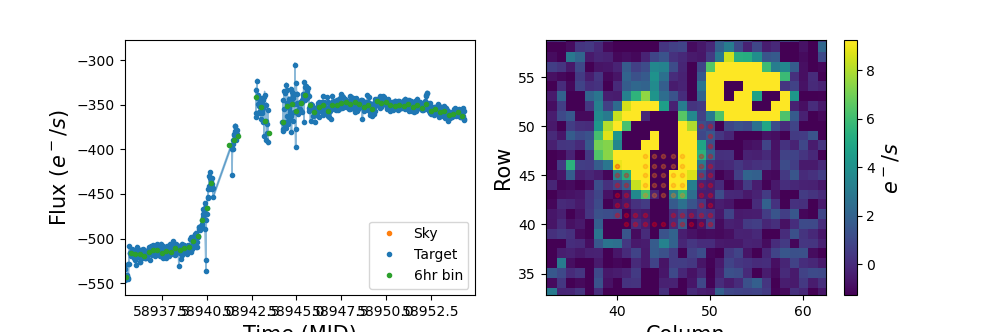

In [41]:
tess = tr.tessreduce(tpf='../../../../data/tess/2020fqv.fits',reduce=True)

<IPython.core.display.Javascript object>


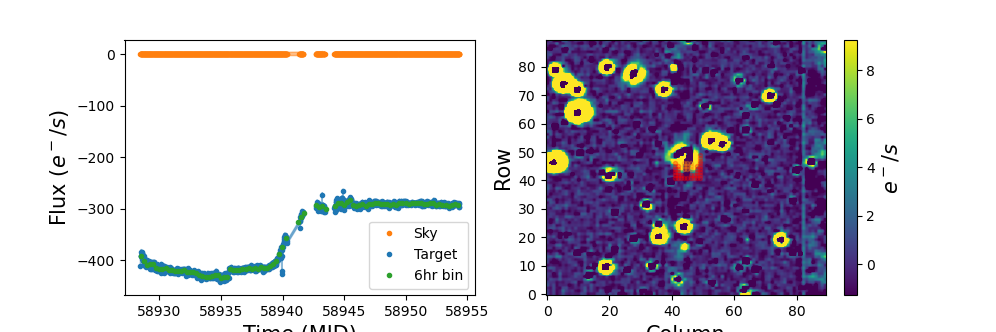

(array([[ 5.89276205e+04,  5.89276414e+04,  5.89276622e+04, ...,
          5.89543286e+04,  5.89543494e+04,  5.89543703e+04],
        [            nan,             nan,             nan, ...,
         -2.97139984e+02, -2.95405212e+02, -2.91334290e+02],
        [            nan,             nan,             nan, ...,
          3.19463205e+00,  3.17931056e+00,  3.21551609e+00]]),
 array([[5.89276205e+04, 5.89276414e+04, 5.89276622e+04, ...,
         5.89543286e+04, 5.89543494e+04, 5.89543703e+04],
        [           nan,            nan,            nan, ...,
         9.58228767e-01, 1.04829812e+00, 1.00944412e+00],
        [           nan,            nan,            nan, ...,
         3.19463205e+00, 3.17931056e+00, 3.21551609e+00]]))

In [57]:
tess.diff_lc(tar_ap=3,plot=True)

<IPython.core.display.Javascript object>


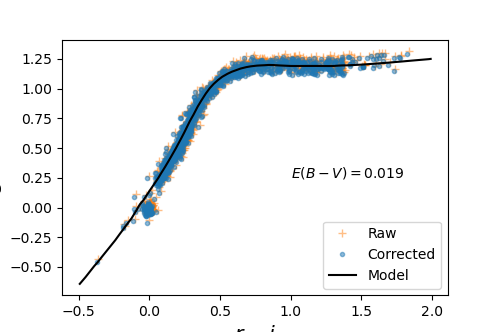

<IPython.core.display.Javascript object>


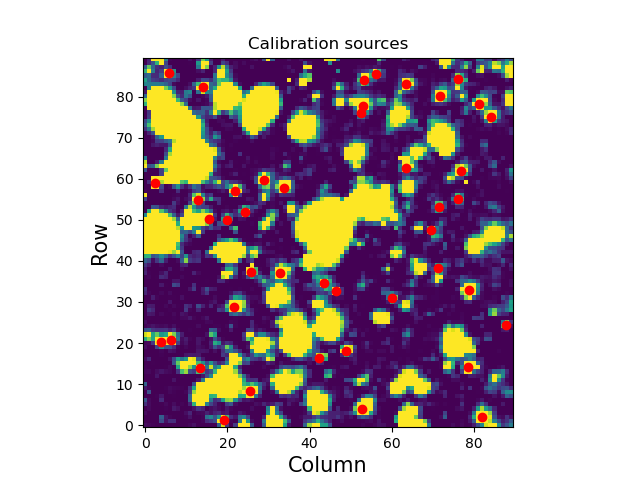

<IPython.core.display.Javascript object>


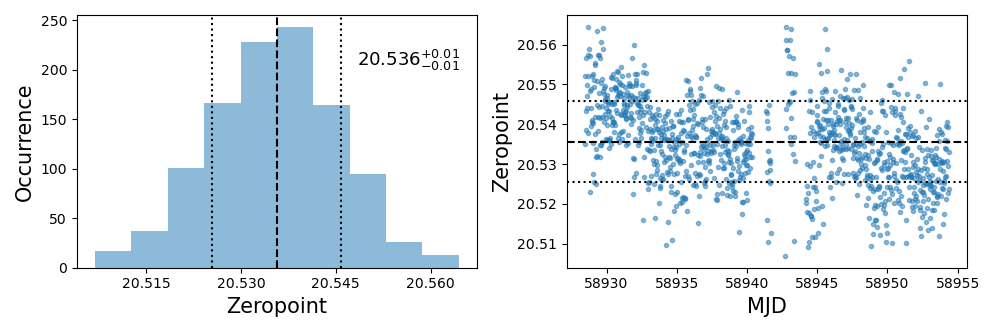

In [58]:
tess.field_calibrate(plot=True)

In [8]:
ps1 = PS1_images(tess.ra,tess.dec,20)

In [43]:
scene = PS1_scene(tess.tpf)

In [52]:
s = rotate(np.flipud(scene),-90)*10**(-1/2.5*(25-tess.zp))

<IPython.core.display.Javascript object>


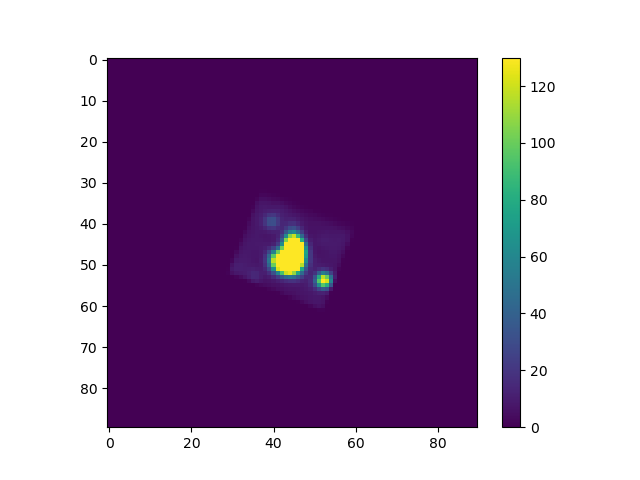

<IPython.core.display.Javascript object>


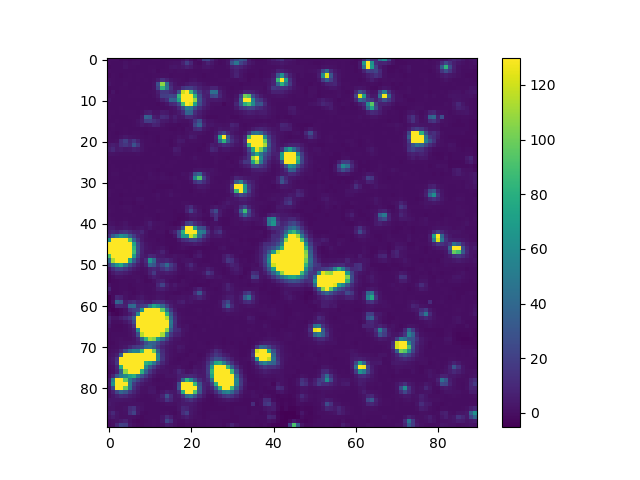

In [53]:
plt.figure()
plt.imshow(s,vmax=130)
plt.colorbar()
plt.figure()
plt.imshow(tess.ref,vmax=130)
plt.colorbar()

<IPython.core.display.Javascript object>


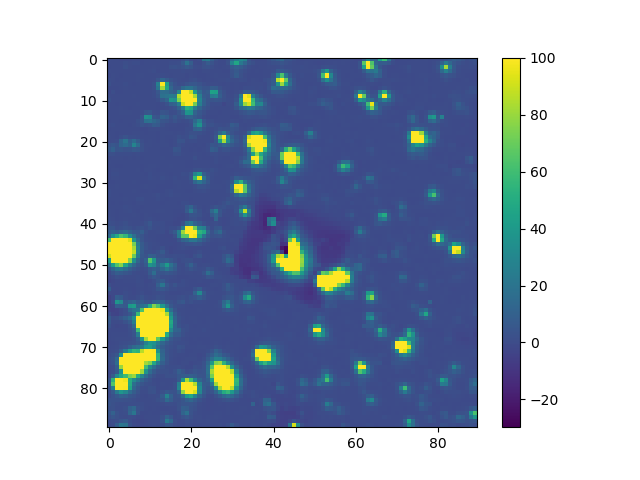

In [55]:
plt.figure()
plt.imshow(tess.ref-s,vmax=100)
plt.colorbar()

<IPython.core.display.Javascript object>


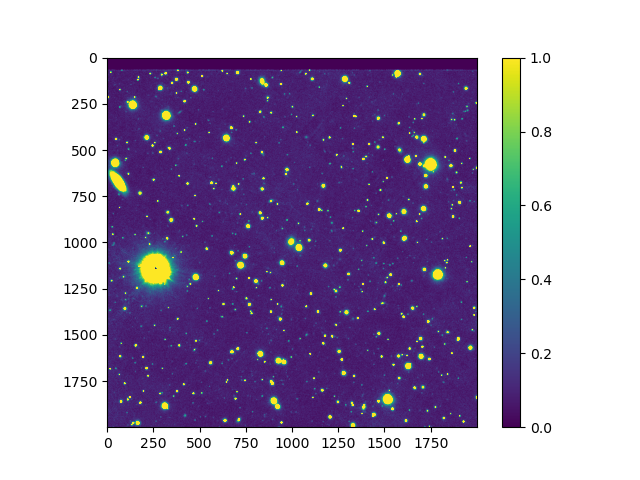

In [21]:
plt.figure()
plt.imshow(PS1_image_to_TESS(ps1),vmax=1)
plt.colorbar()


In [27]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from schwimmbad import MultiPool
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.path as pat
from copy import deepcopy
from scipy.ndimage import  rotate
from astropy.convolution import Gaussian2DKernel
from scipy import signal



def pix2coord(x, y, mywcs):
	"""
	Calculates RA and DEC from the pixel coordinates
	"""
	wx, wy = mywcs.all_pix2world(x, y, 0)
	return np.array([float(wx), float(wy)])

def coord2pix(x, y, mywcs):
	"""
	Calculates RA and DEC from the pixel coordinates
	"""
	wx, wy = mywcs.all_world2pix(x, y, 0)
	return np.array([float(wx), float(wy)])

def Get_TESS_corners(TESS,PS1_wcs):
    y,x = TESS.flux.shape[1:]
    # include the top corners for the last pixels
    x += 1; y += 1

    corners = np.zeros((2,x,y))
    ps_corners = np.zeros((2,x,y))
    x_arr = np.arange(0,x) - 0.5 # offset from the pixel centers 
    y_arr = np.arange(0,y) - 0.5 # offset from the pixel centers 

    for i in range(x):
        for j in range(y):
            corners[:,i,j] = pix2coord(x_arr[i],y_arr[j],TESS.wcs) # why is this offset by 1????
            ps_corners[:,i,j] = coord2pix(corners[0,i,j],corners[1,i,j],PS1_wcs)
            
    return ps_corners

def PS1_image_to_TESS(image,ebv = 0):
    zp = 25
    #gr = (PS1.gmag - PS1.rmag).values
    
    #eg, e = R_val('g',gr=gr,ext=ebv); er, e = R_val('r',gr=gr,ext=ebv)
    #ei, e = R_val('i',gr=gr,ext=ebv); ez, e = R_val('z',gr=gr,ext=ebv)
    #ey, e = R_val('y',gr=gr,ext=ebv); et, e = R_val('tess',gr=gr,ext=ebv)
    #eg = eg  * ebv; er = er  * ebv; ei = ei  * ebv; ez = ez  * ebv
    #ey = ey  * ebv; et = et  * ebv

    g = image['g'] #mag2flux(PS1.gmag.values - eg,zp)
    r = image['r'] #mag2flux(PS1.rmag.values - er,zp)
    i = image['i'] #mag2flux(PS1.imag.values - ei,zp)
    z = image['z'] #mag2flux(PS1.zmag.values - ez,zp)
    y = image['y'] #mag2flux(PS1.ymag.values - ey,zp)
    
    cr = 0.25582823; ci = 0.27609407; cz = 0.35809516
    cy = 0.11244277; cp = 0.00049096

    tess = (cr*r + ci*i + cz*z + cy*y)#*(g/i)**cp
    return tess


def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    """
    Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}&filetypes=stack").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def Get_PS1(RA, DEC,Size, filt='i'):
    '''
    Size limit seems to be around 1000
    '''
    if Size > 30:
        raise ValueError('File is too large!')
    Scale = 100
    size = Size * Scale#int((Size + 2*np.sqrt(1/2)*Size) * Scale ) # last term is a fudge factor 
    fitsurl = geturl(RA,DEC, size=size, filters=filt, format="fits")
    if len(fitsurl) > 0:
        fh = fits.open(fitsurl[0])
        return fh[0]
    else:
        raise ValueError("No PS1 images at for this coordinate") 
        return 
    
def PS1_images(RA, DEC,Size,filt=['g','r','i','z','y']):
    """
    Grab all PS1 images and make a dictionary, size is in terms of TESS pixels, 100 less than actual.
    """
    images = {}
    for f in filt:
        im = Get_PS1(RA, DEC,Size,f)
        ima = im.data 
        m = -2.5*np.log10(ima) + 25 + 2.5*np.log10(im.header['EXPTIME'])
        flux = 10**(-2/5*(m-25))
        flux[~np.isfinite(flux)] = 0
        #ima[~np.isfinite(ima) | (ima < 0)] = 0
        images[f] = flux
        #images['exp' + f] = im.header['EXPTIME']
        
    images['tess'] = PS1_image_to_TESS(images)
    images['wcs'] = WCS(im)
    
    return images



def Make_squares(Corners):
    squares = []
    for n in range(Corners.shape[1]-1):
        for m in range(Corners.shape[2]-1):
            # define the verticies
            square = np.zeros((4,2))
            square[0,:] = [Corners[0,n,m],Corners[1,n,m]]
            square[1,:] = [Corners[0,n+1,m],Corners[1,n+1,m]]
            square[2,:] = [Corners[0,n+1,m+1],Corners[1,n+1,m+1]]
            square[3,:] = [Corners[0,n,m+1],Corners[1,n,m+1]]
            # define the patch
            path = pat.Path(square)
            squares += [path]
    return squares

def Footprint_square(Corners, Points):
    square = np.zeros((4,2))
    square[0,:] = [Corners[0,0,0],Corners[1,0,0]]
    square[1,:] = [Corners[0,-1,0],Corners[1,-1,0]]
    square[2,:] = [Corners[0,-1,-1],Corners[1,-1,-1]]
    square[3,:] = [Corners[0,0,-1],Corners[1,0,-1]]
    path = pat.Path(square)
    contained = path.contains_points(Points)
    points = Points[contained] 
    return points
    
def Pix_sum(Square):
    arr = np.zeros_like(squares)
    contained = squares[Square].contains_points(pspixels)
    if contained.any():
        good = pspixels[contained].astype('int')
        summed = np.nansum(psimage[good[:,1],good[:,0]])
        arr[Square] = summed
    return arr


def Regrid_PS(PS1, Corners):
    dim1, dim2 = Corners.shape[1:]
    dim1 -= 1; dim2 -= 1
    global px, py
    px, py = np.where(PS1)
    global squares
    squares = np.array(Make_squares(Corners))
    square_num = np.arange(0,len(squares))

    points = np.zeros((len(px),2))
    points[:,0] = px
    points[:,1] = py

    global pspixels
    pspixels = Footprint_square(Corners, points)

    global psimage
    psimage = PS1.copy()
    
    pool = MultiPool()
    values = list(pool.map(Pix_sum, square_num))
    pool.close()

    PS_scene = np.array(values)
    PS_scene = np.nansum(PS_scene,axis=0)
    PS_scene = PS_scene.astype('float')
    PS_scene = PS_scene.reshape(dim1,dim2)
    return PS_scene




def PS1_scene(tpf, size=20, convolve = 'PS1', plot = False):
    
    ps1 = PS1_images(tpf.ra, tpf.dec, size)
    ps1_image = ps1['tess']
    ps1_wcs = ps1['wcs']
    
    if np.isnan(ps1_image).any():
        print('PS1 image for the region is incomplete.'
               ' NaNs are present in image. NaN values are set to 0')
        ps1_image[np.isnan(ps1_image)] = 0
    
    if convolve.lower() == 'ps1':
        try:
            kernal = Gaussian2DKernel(1*100) #Interp_PRF(tpf.row + (tpf.flux.value.shape[1]/2), tpf.column + (tpf.flux.value.shape[2]/2),
                                #tpf.camera, tpf.ccd, tpf.sector)
            ps1_image = signal.fftconvolve(ps1_image, kernal,mode='same')
        except MemoryError:
            raise MemoryError("The convolution is too large, try a smaller PS1 image.")
            
    tess_corners = Get_TESS_corners(tpf, ps1_wcs)
    if plot:
        plt.figure(figsize=(6,3))
        #plt.subplot(projection=ps_wcs)
        plt.subplot(1,2,1)
        plt.title('PS1 image')
        plt.imshow(ps1_image/np.nanmax(ps1_image),origin='lower',vmax=.1,cmap='Greys')
        x, y = tpf.flux.value.shape[1:]
        x += 1; y += 1
        z = np.arange(0,x*y,1)
        plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c=z,s=1)

        plt.subplot(1,2,2)
        plt.title('TESS image')
        plt.imshow(tpf.flux[100]/np.nanmax(tpf.flux[100]),origin='lower',vmax=.1)
    
    ps1_scene = Regrid_PS(ps1_image,tess_corners)
    
    if convolve.lower() == 'scene':
        PRF = Get_PRF(tpf.row + (tpf.flux.value.shape[1]/2), tpf.column + (tpf.flux.value.shape[2]/2),
                      tpf.camera, tpf.ccd, tpf.sector)
        ps1_scene = signal.fftconvolve(ps1_scene, PRF, mode='same')
        
    if plot:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.title('PS1 scene')
        plt.imshow(rotate(np.flipud(ps1_scene/np.nanmax(ps1_scene)),-90),origin='lower',vmax=0.1)
        plt.subplot(1,2,2)
        plt.title('TESS image')
        plt.imshow(tess.flux[0]/np.nanmax(tess.flux[0]),origin='lower',vmax=0.1)
    
    return ps1_scene